In [104]:
import os
import time
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVR,SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.spatial.distance import pdist, squareform

In [ ]:
def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 

In [105]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates()
df = df[['Suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['Suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df

,Suburb,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,...,Rental_total_Mar_2019,Rental_total_Jun_2019,Rental_total_Sep_2019,Rental_total_Dec_2019,Rental_total_Mar_2020,Rental_total_Jun_2020,Rental_total_Sep_2020,Rental_total_Dec_2020,Rental_total_Mar_2021,Rental_total_Jun_2021
0,Armadale,200,200,205,210,215,220,225,230,235,...,480,480,480,485,500,500,500,495,450,440
1,Carlton North,260,260,265,270,270,275,280,280,290,...,580,577,580,580,585,590,590,590,580,580
2,Docklands,-,340,-,-,-,-,-,-,320,...,570,580,575,580,570,550,500,460,420,400
3,East Melbourne,265,268,280,273,290,295,300,320,320,...,495,500,520,550,550,550,515,495,450,450
4,East St Kilda,180,180,180,185,185,190,195,195,200,...,420,420,425,425,425,425,420,410,395,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Avondale Heights,185,185,190,200,200,200,210,210,215,...,420,420,420,420,420,410,410,420,410,410
137,Newport,170,175,180,180,180,185,190,190,200,...,480,480,495,495,500,495,495,500,495,490
138,Spotswood,170,175,180,180,180,185,190,190,200,...,480,480,495,495,500,495,495,500,495,490
139,St Albans,150,155,155,160,160,160,160,160,165,...,350,350,355,360,360,360,360,355,350,350


In [106]:
for suburb in [x for x in df.columns][1:]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df = df.fillna(0)
df

,Suburb,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,...,Rental_total_Mar_2019,Rental_total_Jun_2019,Rental_total_Sep_2019,Rental_total_Dec_2019,Rental_total_Mar_2020,Rental_total_Jun_2020,Rental_total_Sep_2020,Rental_total_Dec_2020,Rental_total_Mar_2021,Rental_total_Jun_2021
0,Armadale,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,235.0,...,480.0,480.0,480.0,485.0,500.0,500.0,500.0,495.0,450.0,440.0
1,Carlton North,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,290.0,...,580.0,577.0,580.0,580.0,585.0,590.0,590.0,590.0,580.0,580.0
2,Docklands,0.0,340.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,...,570.0,580.0,575.0,580.0,570.0,550.0,500.0,460.0,420.0,400.0
3,East Melbourne,265.0,268.0,280.0,273.0,290.0,295.0,300.0,320.0,320.0,...,495.0,500.0,520.0,550.0,550.0,550.0,515.0,495.0,450.0,450.0
4,East St Kilda,180.0,180.0,180.0,185.0,185.0,190.0,195.0,195.0,200.0,...,420.0,420.0,425.0,425.0,425.0,425.0,420.0,410.0,395.0,385.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Avondale Heights,185.0,185.0,190.0,200.0,200.0,200.0,210.0,210.0,215.0,...,420.0,420.0,420.0,420.0,420.0,410.0,410.0,420.0,410.0,410.0
137,Newport,170.0,175.0,180.0,180.0,180.0,185.0,190.0,190.0,200.0,...,480.0,480.0,495.0,495.0,500.0,495.0,495.0,500.0,495.0,490.0
138,Spotswood,170.0,175.0,180.0,180.0,180.0,185.0,190.0,190.0,200.0,...,480.0,480.0,495.0,495.0,500.0,495.0,495.0,500.0,495.0,490.0
139,St Albans,150.0,155.0,155.0,160.0,160.0,160.0,160.0,160.0,165.0,...,350.0,350.0,355.0,360.0,360.0,360.0,360.0,355.0,350.0,350.0


In [107]:
from sklearn.linear_model import Ridge
train_x = df[['Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021']]
train_y = df['Rental_total_Jun_2021']
ridge = Ridge(alpha=50)
ridge.fit(train_x, train_y)
pred=ridge.predict(train_x)

ridge.score(train_x, train_y)

0.9970160077680822

In [ ]:
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

### Feature Engineering

In [ ]:
# 9.29 start now:

In [108]:
property_df = pd.read_csv('../data/curated/property_cleaned.csv', low_memory = False)
property_df['cloest_train_station'] = property_df['cloest_train_station'].apply(eval)
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [109]:
# drop station for now
property_df_temp = property_df.drop(columns = ['cloest_train_station', 'cloest_tram_stop', 'cloest_bus_stop'])


In [110]:
property_df_temp.columns

Index(['address', 'rent_weekly', 'floor', 'suburb', 'postcode', 'type',
       'furnitured', 'pool', 'gym', 'num_bed',
       ...
       'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR',
       'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION',
       'BUS'],
      dtype='object', length=662)

In [111]:
Rental_list = []
Others = []
for col in property_df_temp.columns:
    if 'Rental' in col:
        Rental_list.append(col)
    else:
        Others.append(col)

In [112]:
#Other_df = property_df_temp[Others].copy()
Other_df = property_df_temp.copy()
# replace type name
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat', 'Apartment / Unit / Flat / Penhouse')
Other_df['type'] = Other_df['type'].replace('Penthouse', 'Apartment / Unit / Flat / Penhouse')

# Change to numerical
Other_df = Other_df.replace('-', -1)

Other_df['furnitured'] = Other_df['furnitured'].replace('Yes', 1)
Other_df['furnitured'] = Other_df['furnitured'].replace('No', 0)

Other_df['pool'] = Other_df['pool'].replace('Yes', 1)
Other_df['pool'] = Other_df['pool'].replace('No', 0)

Other_df['gym'] = Other_df['gym'].replace('Yes', 1)
Other_df['gym'] = Other_df['gym'].replace('No', 0)

# fill
Other_df = Other_df.fillna(-1)

# drop
Other_df = Other_df.drop(columns=['postcode'])

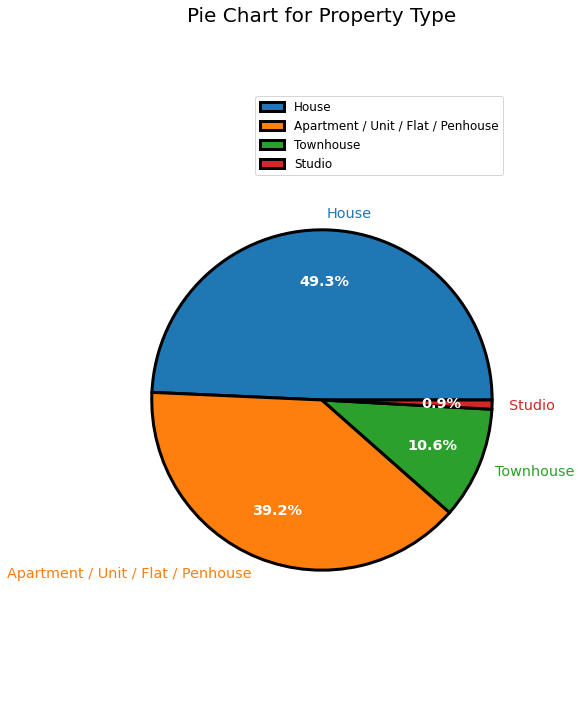

In [43]:
pie_data = Other_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,10))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [113]:
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
Other_df['type'] = Other_df['type'].replace('Studio', 2)
Other_df['type'] = Other_df['type'].replace('Townhouse', 3)
Other_df['type'] = Other_df['type'].replace('House', 4)
Other_df['type'] = Other_df['type'].replace('Penthouse', 5)

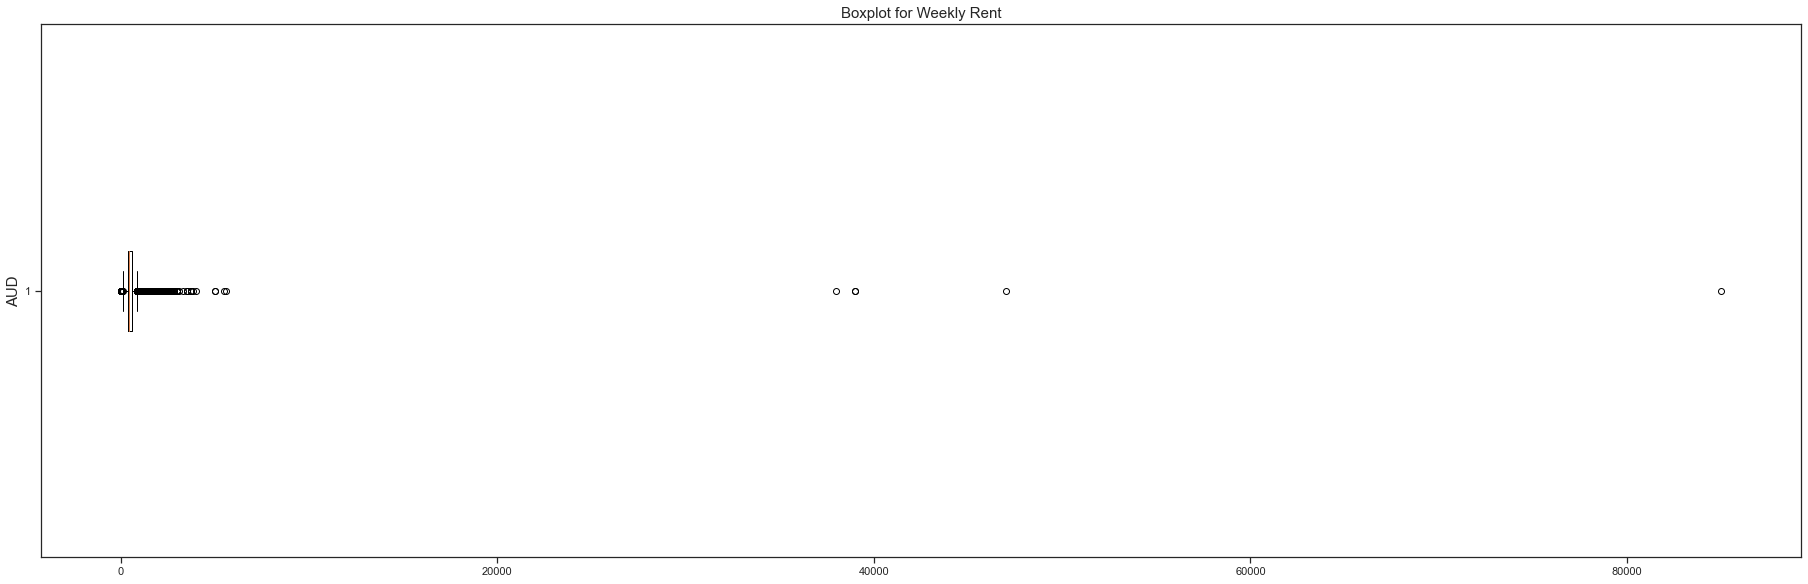

In [114]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

<AxesSubplot:title={'center':'weekly rent distribution'}, xlabel='rent_weekly', ylabel='Count'>

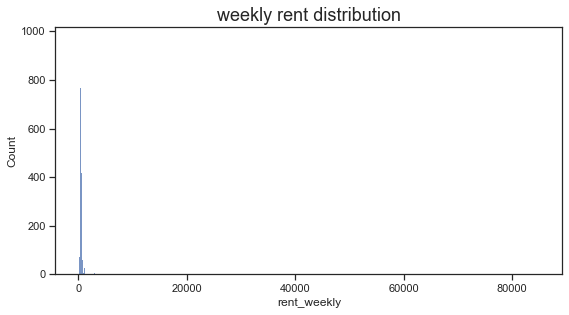

In [115]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution', fontsize=18)
sns.histplot(Other_df['rent_weekly'])

In [116]:
Other_df["rent_weekly"].describe()

count    14505.000000
mean       531.953326
std       1008.667255
min          1.000000
25%        385.000000
50%        450.000000
75%        570.000000
max      85000.000000
Name: rent_weekly, dtype: float64

In [117]:
Q1 = Other_df["rent_weekly"].quantile(0.25)
Q3 = Other_df["rent_weekly"].quantile(0.75)
IQR = Q3 - Q1
Other_df = Other_df[~((Other_df["rent_weekly"] < (Q1 - 1.5 * IQR)) | (Other_df["rent_weekly"] > (Q3 + 1.5 * IQR)))]
Other_df = Other_df.reset_index(drop=True)

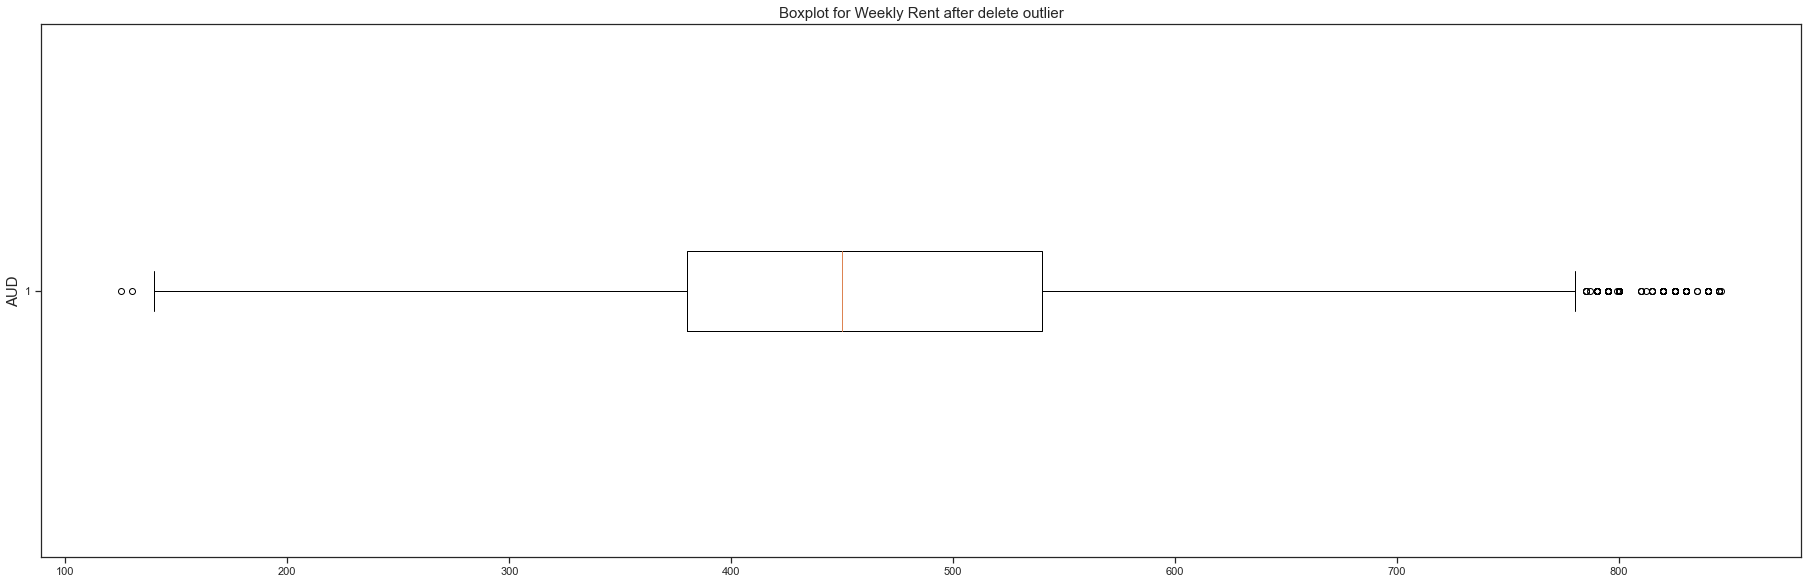

In [118]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent after delete outlier',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_after.png')

/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'weekly rent distribution after delete outlier'}, xlabel='rent_weekly', ylabel='Density'>

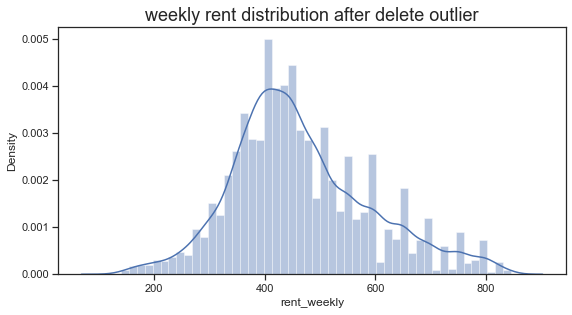

In [119]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution after delete outlier', fontsize=18)
sns.distplot(Other_df['rent_weekly'])

In [51]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

In [120]:
Other_df = convert_suburb(Other_df)

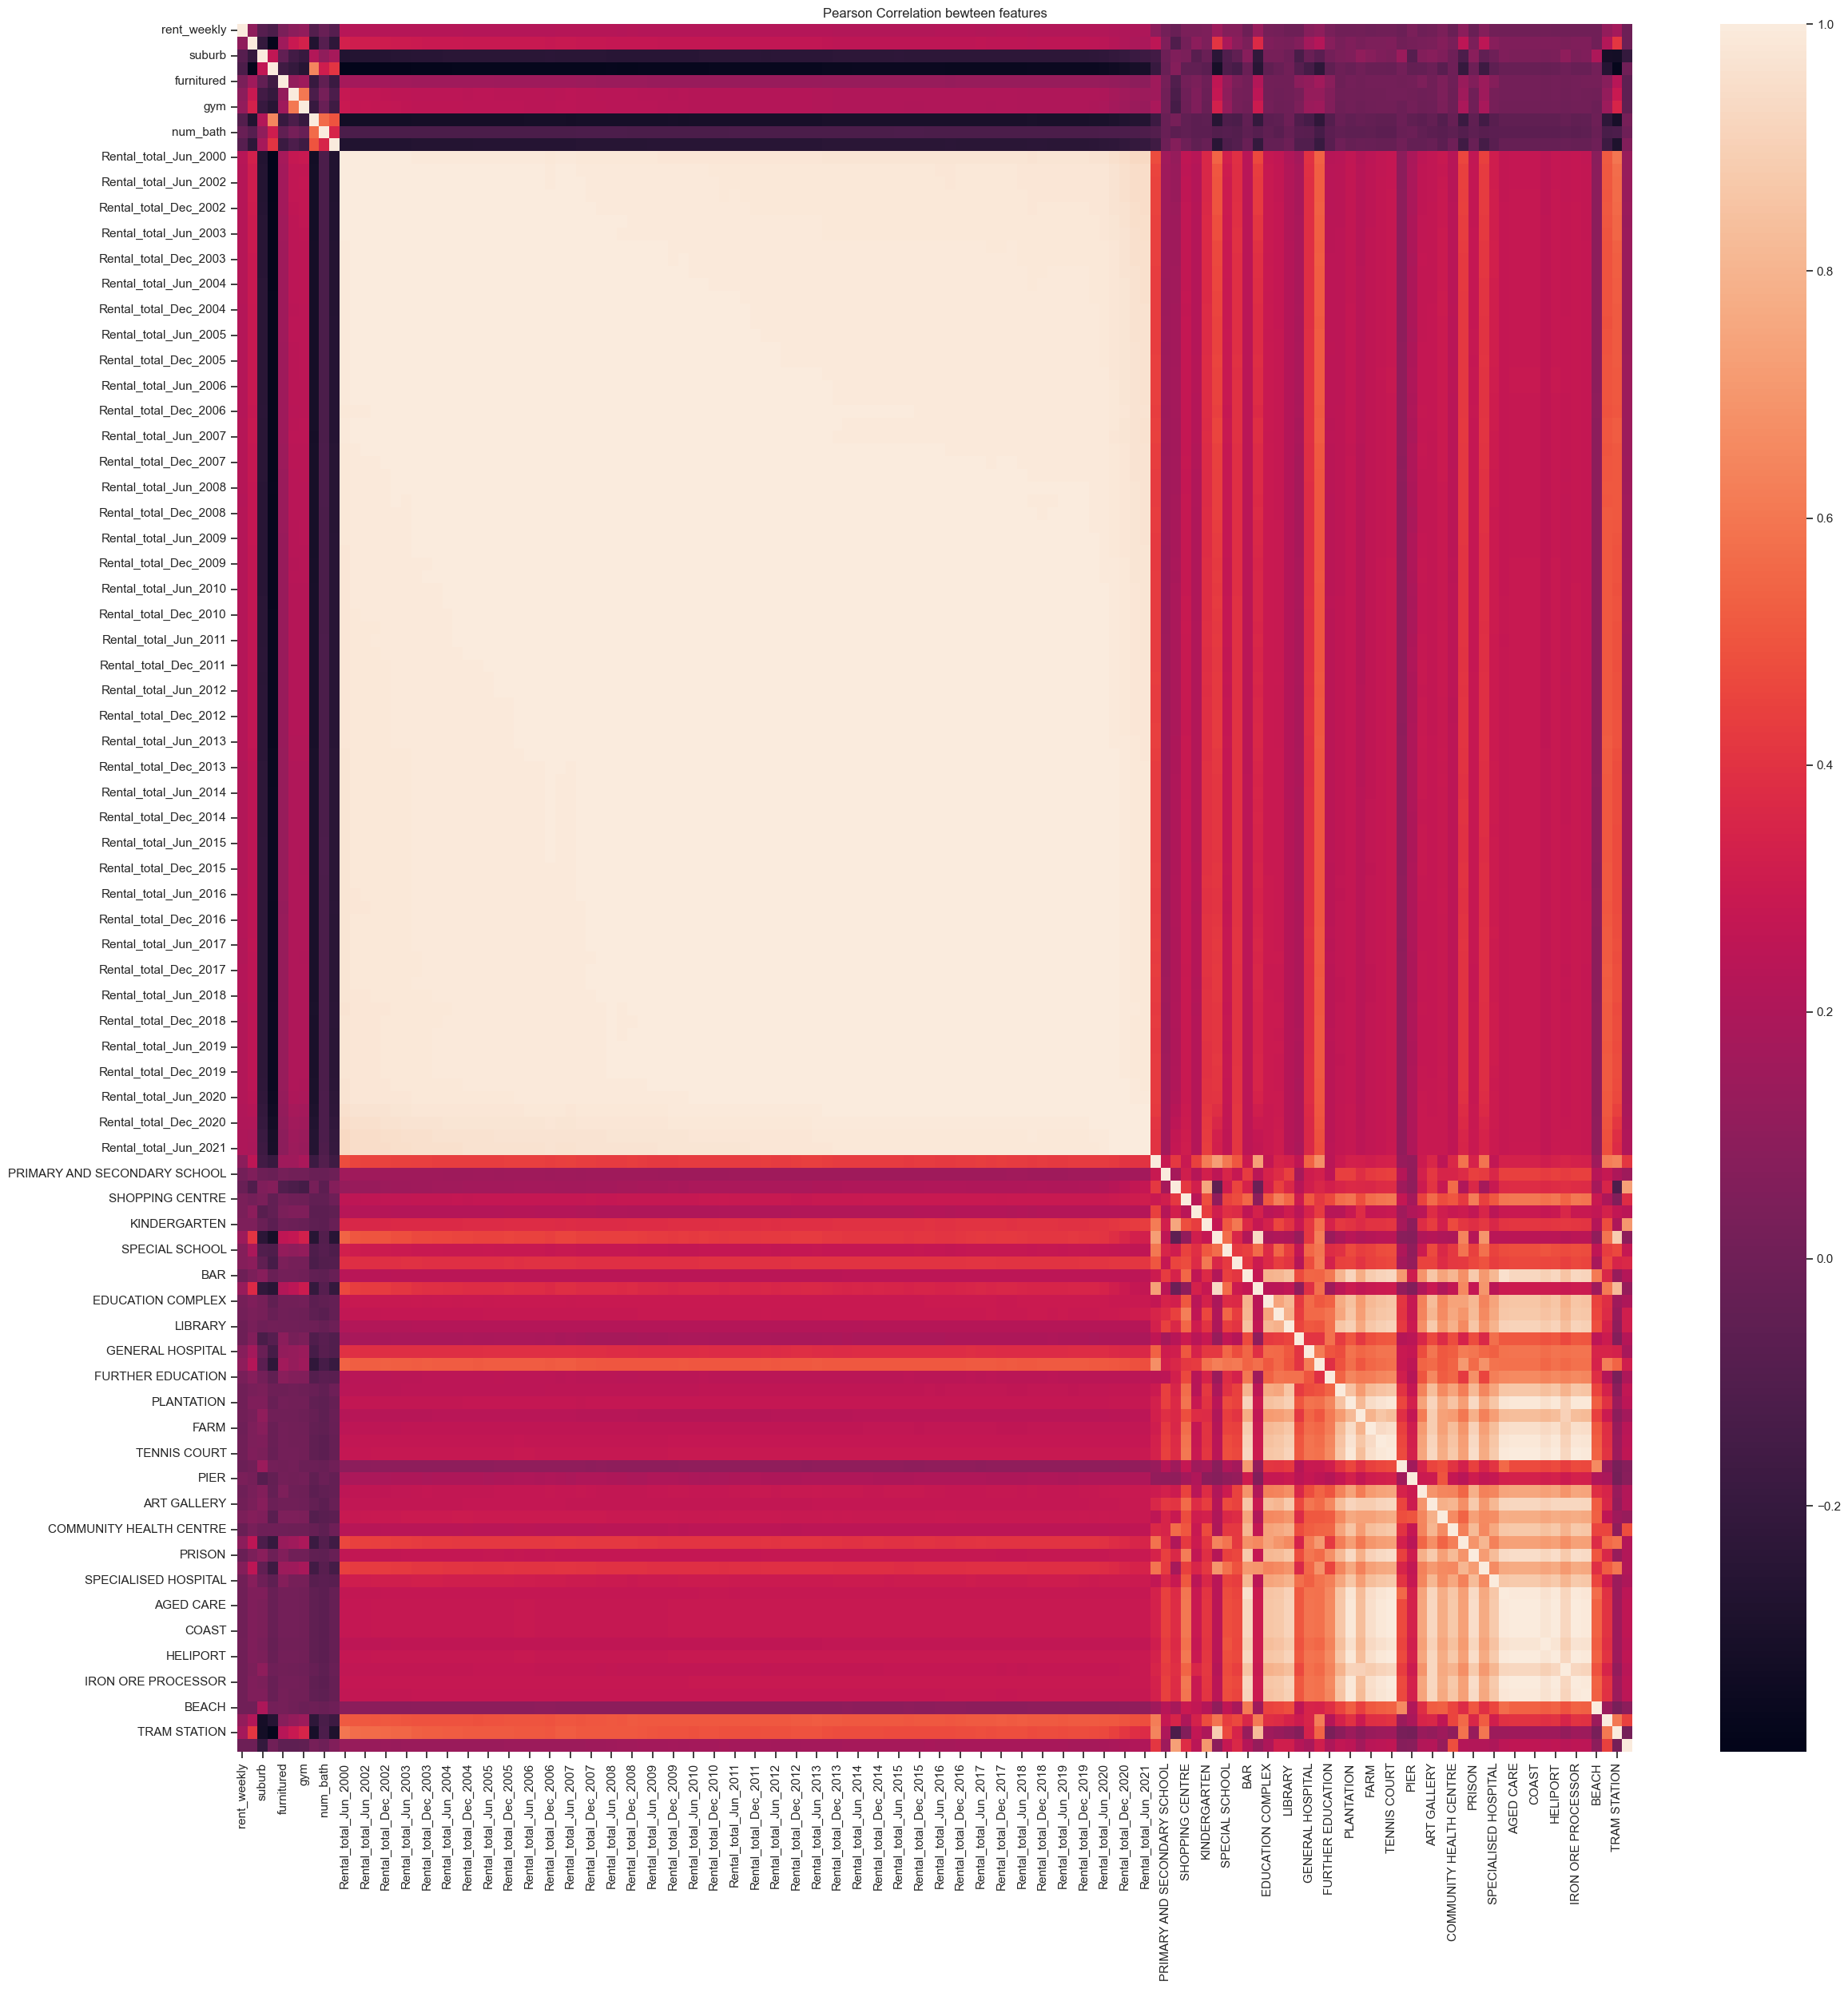

In [121]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [122]:
print(Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).to_dict())
#Other_df.corr().abs().sort_values(by=['rent_weekly'],ascending=True).iloc[0]

{'rent_weekly': {'rent_weekly': 1.0, 'Rental_total_Jun_2000': 0.2301057906513734, 'Rental_total_Sep_2002': 0.22840874040848153, 'Rental_total_Mar_2002': 0.22838363134952694, 'Rental_total_Jun_2002': 0.22809608464810005, 'Rental_total_Dec_2002': 0.22665651722825605, 'Rental_total_Mar_2003': 0.22565303056946398, 'Rental_total_Dec_2007': 0.2254839260699567, 'Rental_total_Jun_2007': 0.22505415896867173, 'Rental_total_Jun_2003': 0.2247739965891859, 'Rental_total_Mar_2008': 0.22455097136209348, 'Rental_total_Dec_2008': 0.22453433028401856, 'Rental_total_Jun_2004': 0.22448952016469437, 'Rental_total_Sep_2007': 0.22432704895923583, 'Rental_total_Dec_2003': 0.22420196519323743, 'Rental_total_Jun_2008': 0.22403947302393154, 'Rental_total_Mar_2007': 0.22403943009786065, 'Rental_total_Sep_2004': 0.2240143550670554, 'Rental_total_Sep_2003': 0.2240064465970495, 'Rental_total_Mar_2004': 0.2239663793511078, 'Rental_total_Sep_2008': 0.22376728732786705, 'Rental_total_Dec_2004': 0.22334429479020546, 'Re

In [123]:
other_lis = []
column_lis = []
for col in Other_df.columns:
    if (('Rental_total' in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        column_lis.append(col)
    else:
        other_lis.append(col)

In [124]:
Other_df = Other_df[column_lis]

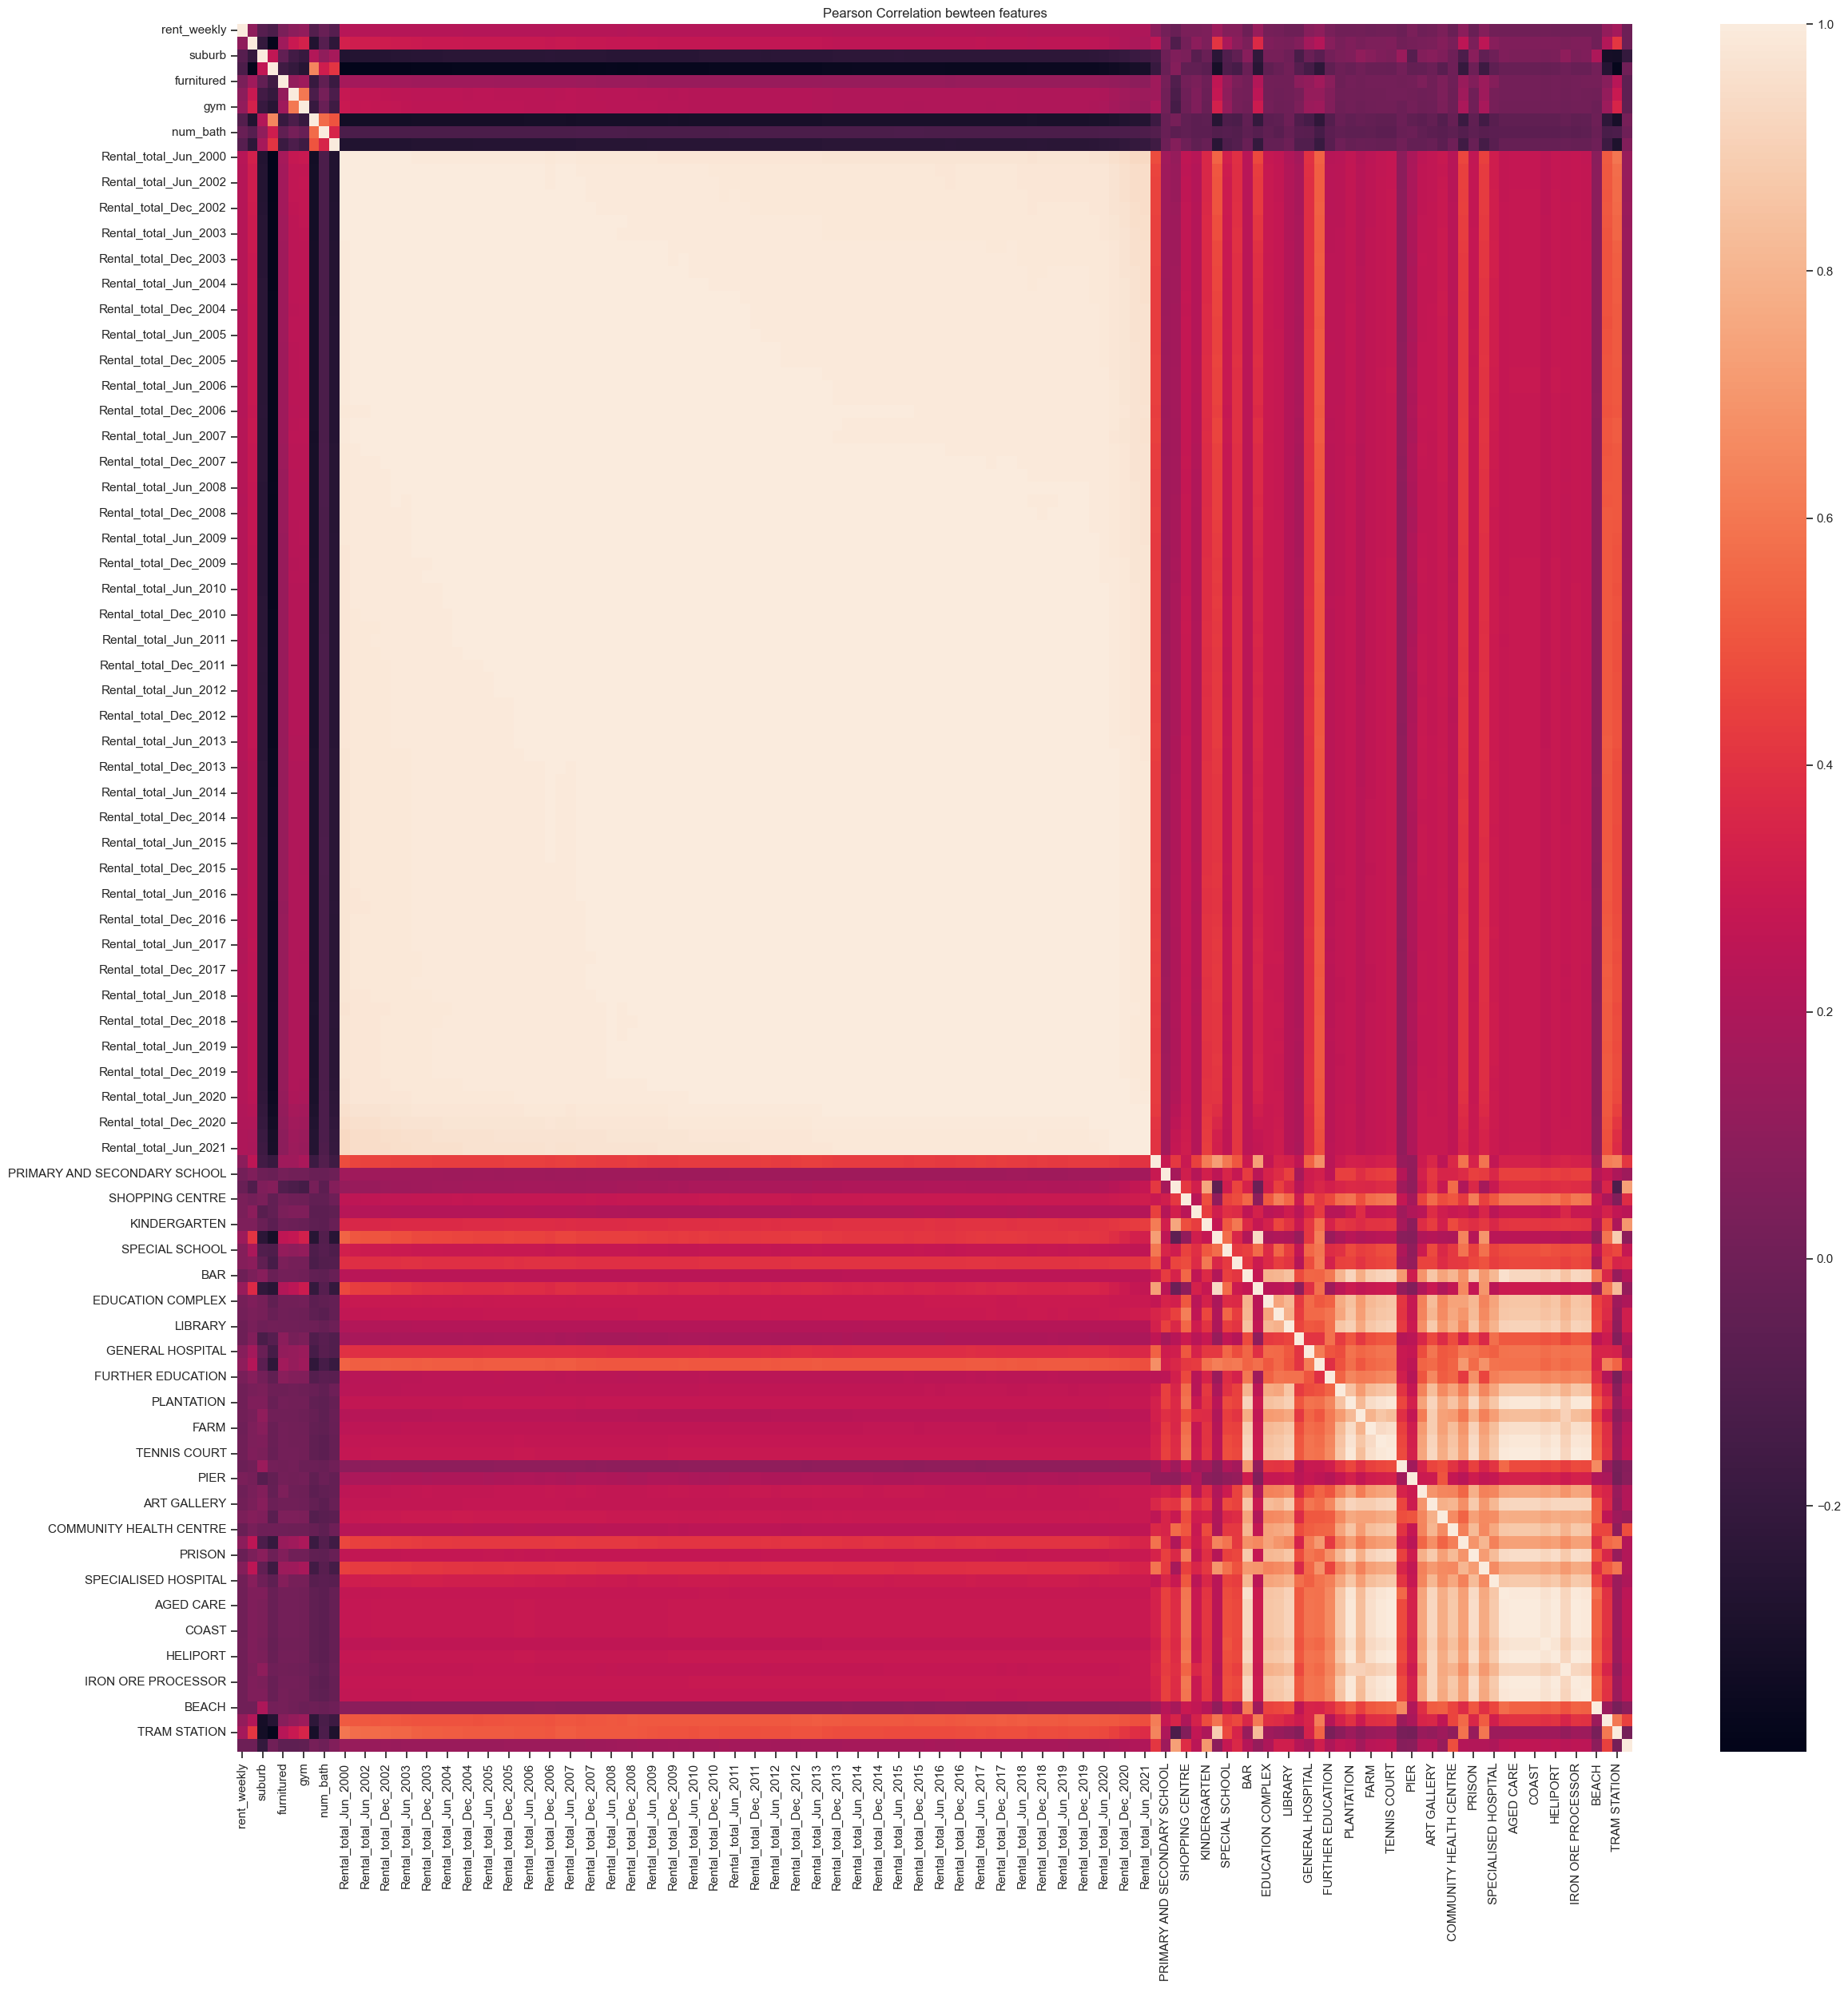

In [125]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [126]:
Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
Rental_total_Jun_2000,0.230106
Rental_total_Sep_2002,0.228409
Rental_total_Mar_2002,0.228384
Rental_total_Jun_2002,0.228096
...,...
PLAYGROUND,0.003025
BEACH,0.001425
VINEYARD,0.001319
BANK,0.000547


In [127]:
# chi2, mutual_info_classif, f_classif
X = Other_df.copy()
X = X.reset_index(drop=True)
Y = X['rent_weekly'].copy()
X = X.drop(columns=['rent_weekly','address','coordinates'])
x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

In [128]:
def LR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [129]:
def SVM_acc(x_train, x_test, y_train, y_test):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lsvc_clf.score(x_train, y_train)
    test_acc = lsvc_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def SVM_pred(x_train, x_test, y_train):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)
    # make a prediction
    pred = lsvc_clf.predict(x_test)
    
    return pred

In [130]:
def LinearR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LinearR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [131]:
def Lasso_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lasso_clf.score(x_train, y_train)
    test_acc = lasso_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Lasso_pred(x_train, x_test, y_train):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)
    # make a prediction
    pred = lasso_clf.predict(x_test)
    
    return pred

In [132]:
def Ridge_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = ridge_clf.score(x_train, y_train)
    test_acc = ridge_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Ridge_pred(x_train, x_test, y_train):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)
    # make a prediction
    pred = ridge_clf.predict(x_test)
    
    return pred

In [133]:
def GridSearch(pipeline, params, x, y):
    # initilized Grid Search
    grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)
    print("Pipeline: ", [i for i, _ in pipeline.steps])
    t=time.time()
    grid_search.fit(x,y)
    print("finish %0.2fs\n" % (time.time()-t))   #show the run time
    
    # show top 5 parameters
    mean_score = grid_search.cv_results_["mean_test_score"]
    parementer_ls = grid_search.cv_results_["params"]
    for i in mean_score.argsort()[-5:]:
        print(parementer_ls[i])
        print(mean_score[i])
        print("----"*30)
        
        
    return grid_search

In [85]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", LinearRegression())])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

Pipeline:  ['kbest', 'clf']
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/pipeline

finish 58.45s

{'kbest__k': 30, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 50, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 80, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 100, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 130, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------

{'kbest__k': 130,
 'kbest__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [101]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", SVC(max_iter = 20000))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

Pipeline:  ['kbest', 'clf']
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucinda/opt/anaconda

finish 217.78s

{'kbest__k': 30, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 50, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 80, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 100, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 130, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
-----------------------------------------------------------------------------------------------------------------

{'kbest__k': 100,
 'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True, force_finite=True)>}

In [86]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", Lasso(alpha=1.0))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

Pipeline:  ['kbest', 'clf']
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/pipeline

finish 53.23s

{'kbest__k': 30, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 50, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 80, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 100, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 130, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------

/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.661e+07, tolerance: 1.495e+04
  model = cd_fast.enet_coordinate_descent(


{'kbest__k': 130,
 'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True, force_finite=True)>}

In [87]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", Ridge(alpha=1.0))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

Pipeline:  ['kbest', 'clf']
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/pipeline

finish 51.75s

{'kbest__k': 30, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 50, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 80, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 100, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------------
{'kbest__k': 130, 'kbest__score_func': <function chi2 at 0x7faeb49660d0>}
nan
------------------------------------------------------------------------------------------------------------------

{'kbest__k': 130,
 'kbest__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [ ]:
#Select features by chi-square with data after word vectorization

# fit data for Bow
kbest = SelectKBest(score_func = , k = ).fit(x_train, y_train)

# transform data
kbest_train_x = kbest.transform(x_train)
kbest_test_x = kbest.transform(x_test)


In [98]:
LR = {}
print("The accuracy of LogisticRegression")
train_acc, test_acc = LR_acc(x_train, x_test, y_train, y_test)
LR["train_acc"] = train_acc
LR["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

SVM = {}
print("The accuracy of SVM")
train_acc, test_acc = SVM_acc(x_train, x_test, y_train, y_test)
SVM["train_acc"] = train_acc
SVM["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

LinearR = {}
print("The accuracy of LinearRegression")
train_acc, test_acc = LinearR_acc(x_train, x_test, y_train, y_test)
LinearR["train_acc"] = train_acc
LinearR["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

ridge = {}
print("The accuracy of Ridge")
train_acc, test_acc = Ridge_acc(x_train, x_test, y_train, y_test)
ridge["train_acc"] = train_acc
ridge["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

lasso = {}
print("The accuracy of Lasso")
train_acc, test_acc = Lasso_acc(x_train, x_test, y_train, y_test)
lasso["train_acc"] = train_acc
lasso["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

The accuracy of LogisticRegression


/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy:  0.06253981737099172
Test Accuracy:  0.057716125836016846
********************************
The accuracy of SVM
Train Accuracy:  0.06179655977914632
Test Accuracy:  0.05845925191974238
********************************
The accuracy of LinearRegression
Train Accuracy:  0.12199169188640824
Test Accuracy:  0.09056877403880181
********************************
The accuracy of Ridge
Train Accuracy:  0.12186672179146996
Test Accuracy:  0.09036888539711518
********************************
The accuracy of Lasso
Train Accuracy:  0.07594956457463697
Test Accuracy:  0.07324680454987775
********************************


/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.661e+07, tolerance: 1.495e+04
  model = cd_fast.enet_coordinate_descent(


In [99]:
acc_dict = [LR, SVM, LinearR, ridge,lasso]
index = ["LogisticRegression", "SVM", "LinearRegression", "Ridge", "Lasso"]
data = [[0,0],[0,0],[0,0],[0,0],[0,0]]
acc_df = pd.DataFrame(data, columns=['train_acc','test_acc'], index =index)

for i in range(5):
    model_name = index[i]
    acc_df.loc[model_name] = list(acc_dict[i].values())

In [100]:
display(acc_df.sort_values(by=['test_acc'],ascending=False))

,train_acc,test_acc
LinearRegression,0.121992,0.090569
Ridge,0.121867,0.090369
Lasso,0.075950,0.073247
SVM,0.061797,0.058459
LogisticRegression,0.062540,0.057716


In [ ]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))